In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
NPROC = 80
buffer_size = 160000
range_min = "10"
power_limit = 150

path="/content/drive/MyDrive/mgr/final/apl11/"
program_configs = [
    {
        "name": "ms",
        "title": "Merge sort",
        "csv_path": path+"ms_results.csv"
    },
    {
        "name": "mx",
        "title": "Matrix",
        "csv_path": path+"mx_results.csv"
    },
    {
        "name": "mb",
        "title": "Mandelbrot",
        "csv_path": path+"mb_results.csv"
    }
]
model_names = {
        0: "Dynamic for",
        1: "Tasking",
        2: "Integrated master"
    }




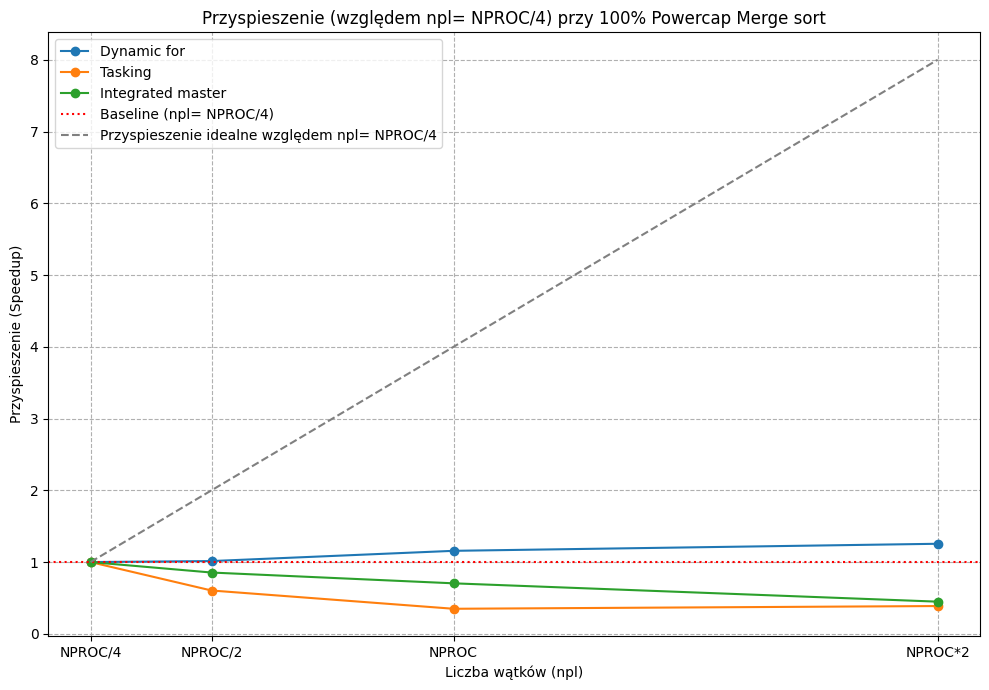

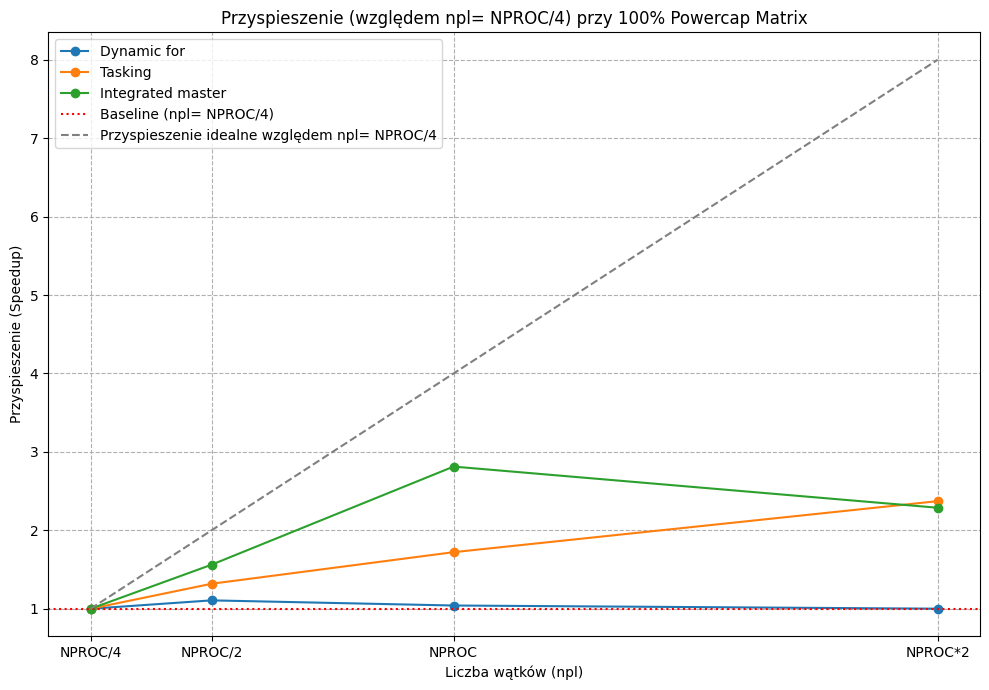

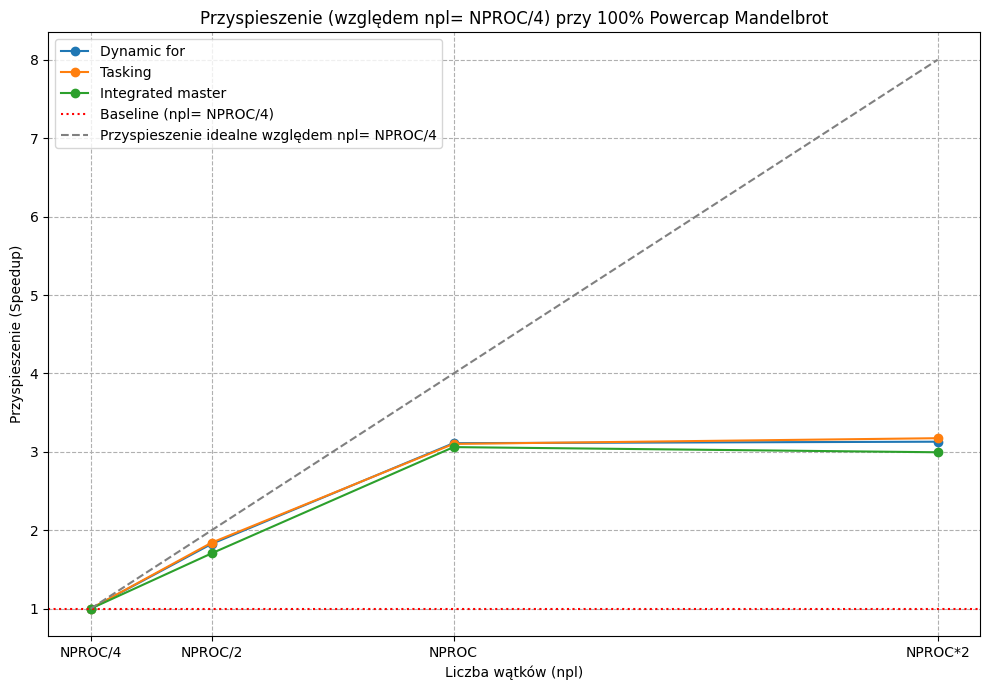

In [ ]:

for config in program_configs:
    program_name = config["name"]
    program_title = config["title"]
    csv_path = config["csv_path"]

    try:
        df = pd.read_csv(csv_path, sep=None, engine="python")
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, sep=None, engine="python", encoding="cp1250")


    df.columns = df.columns.str.strip()

    df = df.copy()
    df["energy_J"] = df["energy_used_RAPL"] / 1e6

    grp_cols = ["model", "power_limit", "problem_size", "npl"]
    df_agg = (
        df.groupby(grp_cols, as_index=False)
          .agg(
              working_time_mean=("working_time", "mean"),
              working_time_std =("working_time", "std"),
              energy_J_mean    =("energy_J", "mean"),
              energy_J_std     =("energy_J", "std"),
              count            =("working_time", "size")
          )
    )
    df_agg[["working_time_std","energy_J_std"]] = df_agg[["working_time_std","energy_J_std"]].fillna(0)


    if program_name== "ms":
        problem_size_selected = 100000000
    elif program_name == "mx":
        problem_size_selected = 4000
    elif program_name == "mb":
        problem_size_selected = 3000

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    df_filtered = df_agg[
        (df_agg['problem_size'] == problem_size_selected) &
        (df_agg['power_limit'] == power_limit)
    ].copy()


    npl_values = sorted(df_filtered['npl'].unique())

    for model_id, model_name in model_names.items():

        df_model = df_filtered[df_filtered['model'] == model_id].sort_values('npl')

        if df_model.empty:
            print(f"Brak danych dla modelu: {model_name} przy 100% powercap")
            continue


        try:
            baseline_row = df_model[df_model['npl'] == NPROC/4].iloc[0]
            baseline_time = baseline_row['working_time_mean']
        except IndexError:
            print(f"Brak danych bazowych (npl= NPROC/4) dla modelu: {model_name}")
            continue


        df_model['speedup'] = baseline_time / df_model['working_time_mean']


        ax.plot(
            df_model['npl'],
            df_model['speedup'],
            marker='o',
            linestyle='-',
            label=model_name
        )




    if npl_values:

        ax.axhline(y=1, color='red', linestyle=':', label='Baseline (npl= NPROC/4)')

        ideal_x = np.array(npl_values)
        ideal_y = ideal_x / (NPROC/4)
        ax.plot(ideal_x, ideal_y, linestyle='--', color='gray', label='Przyspieszenie idealne względem npl= NPROC/4')


        ax.set_xticks(npl_values)
        label_map = {
            NPROC/4: "NPROC/4",
            NPROC/2: "NPROC/2",
            NPROC: "NPROC",
            NPROC * 2: "NPROC*2"
        }
        new_labels = [label_map.get(n, str(n)) for n in npl_values]
        ax.set_xticklabels(new_labels, rotation=0)

    ax.set_title(f'Przyspieszenie (względem npl= NPROC/4) przy 100% Powercap {program_title}')
    ax.set_xlabel('Liczba wątków (npl)')
    ax.set_ylabel('Przyspieszenie (Speedup)')

    ax.grid(True, which='both', ls='--')
    ax.legend()

    plt.tight_layout()
    plt.show()

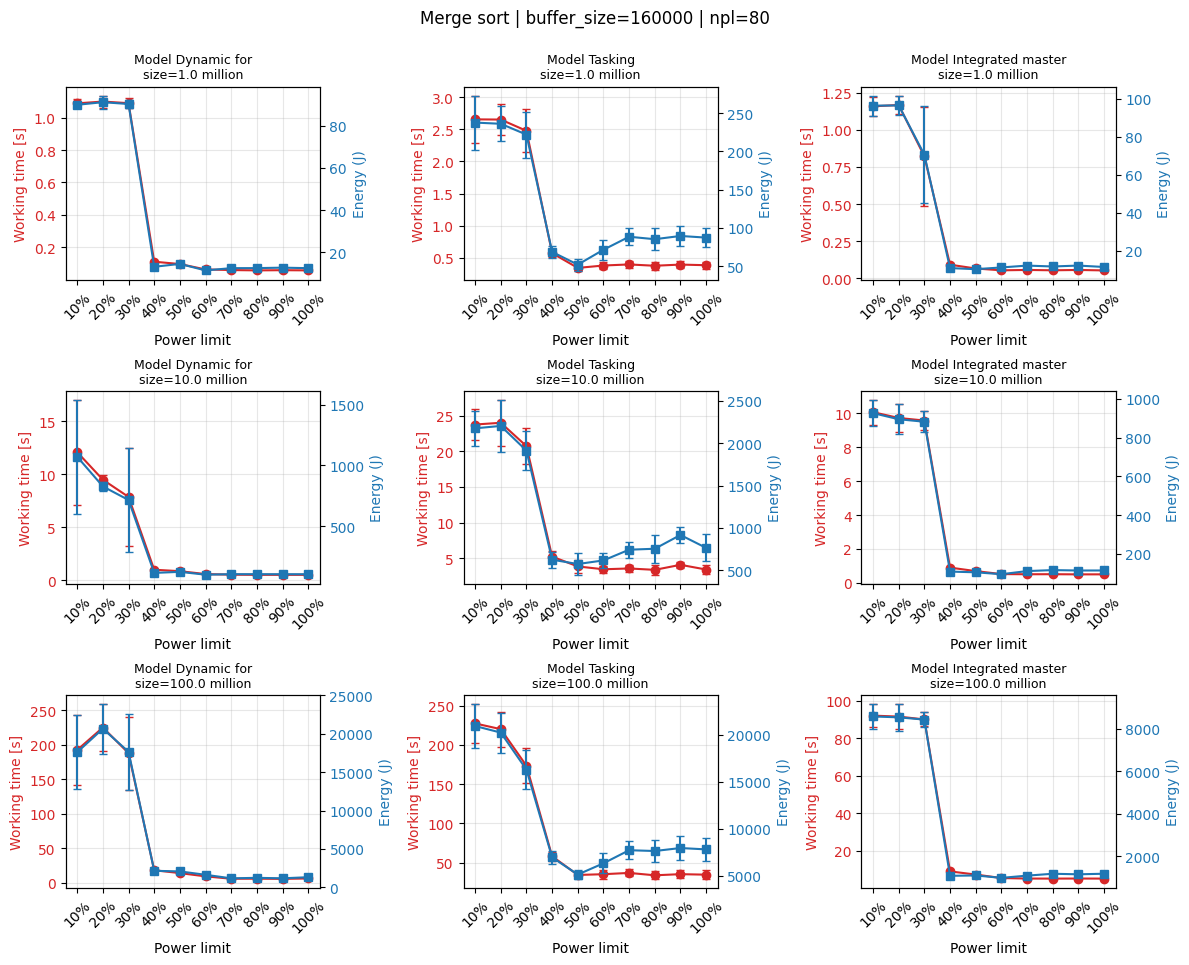

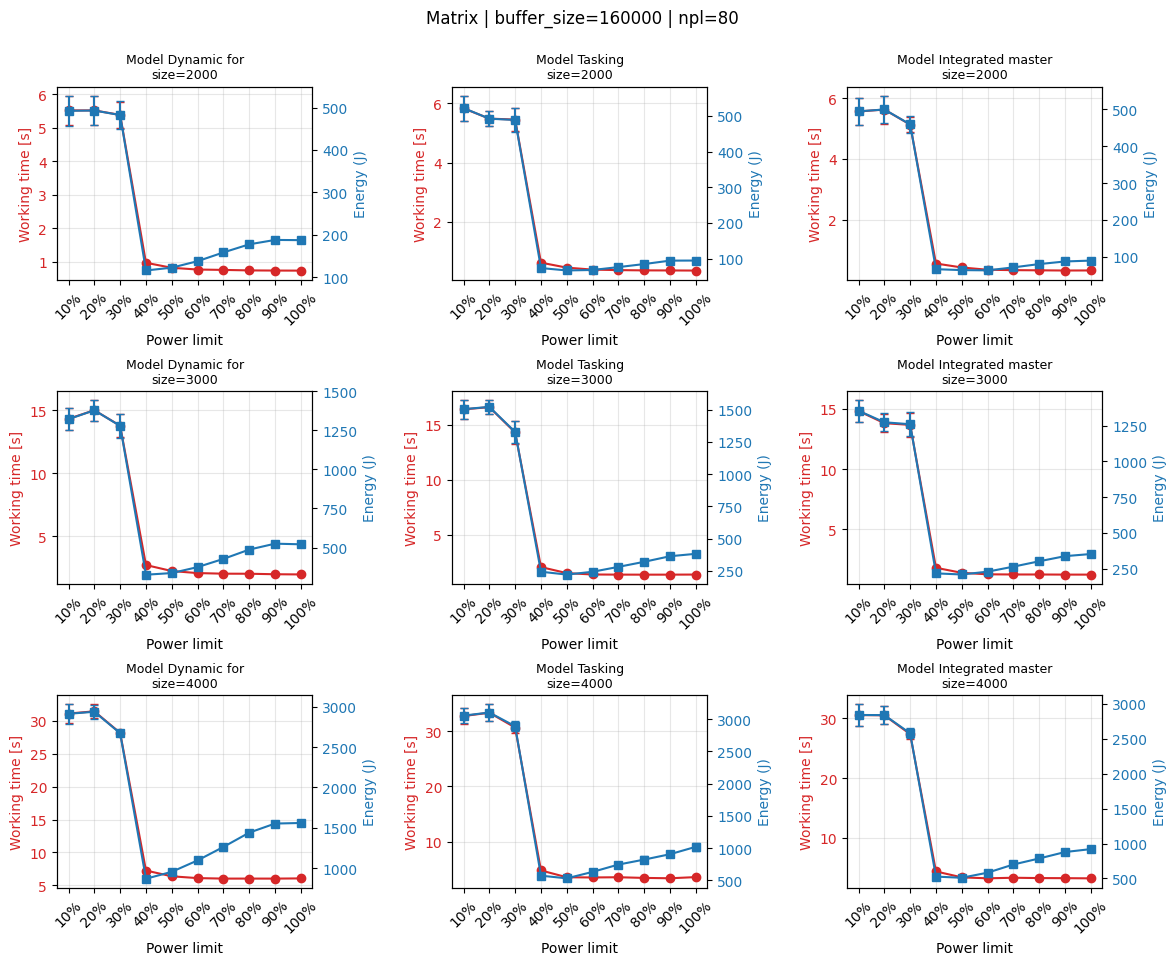

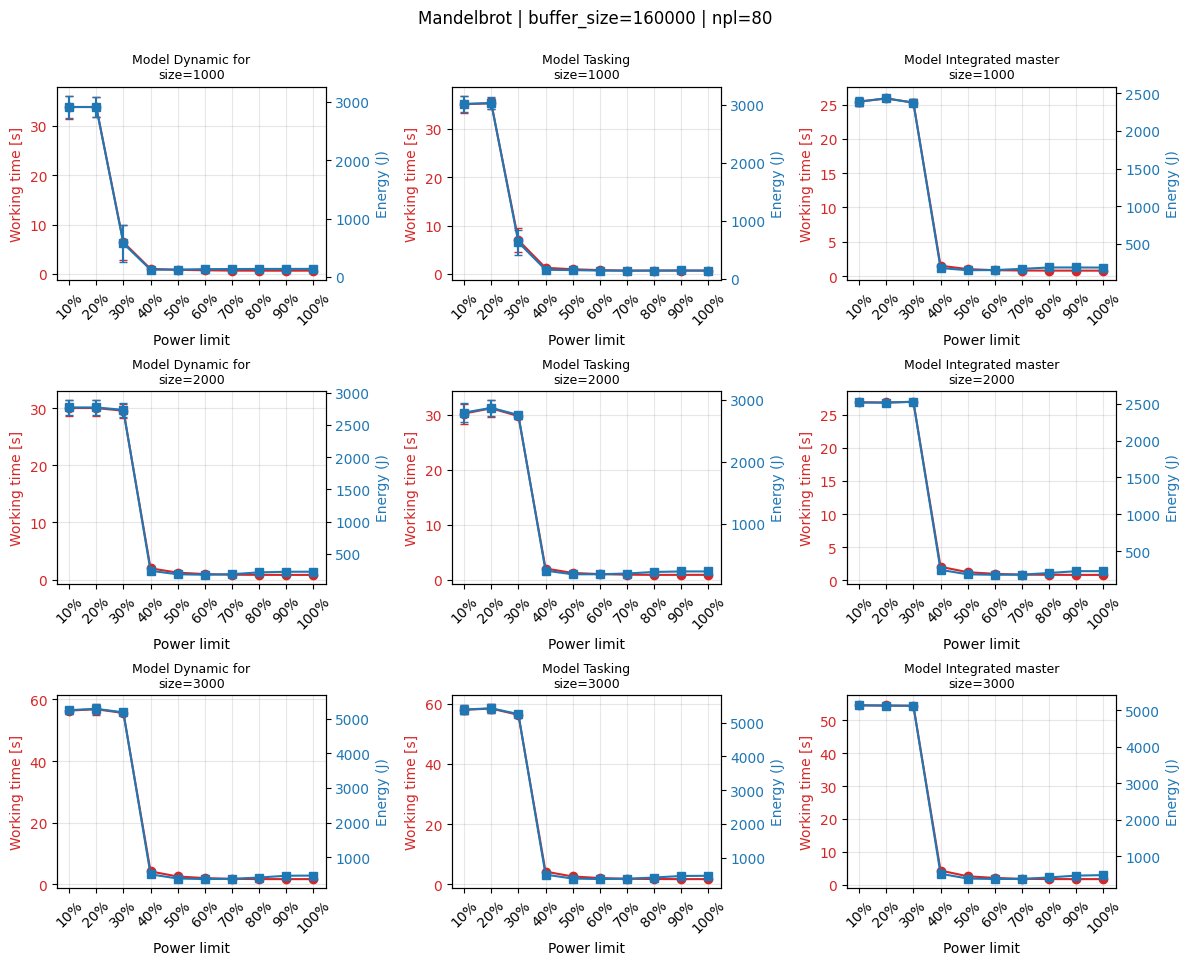

In [9]:
for config in program_configs:
    program_name = config["name"]
    program_title = config["title"]
    csv_path = config["csv_path"]

    try:
        df = pd.read_csv(csv_path, sep=None, engine="python")
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, sep=None, engine="python", encoding="cp1250")

    rows, cols = 3, 3
    total_plots = rows * cols
    df.columns = df.columns.str.strip()

    df = df.copy()
    df["energy_J"] = df["energy_used_RAPL"] / 1e6

    df_base = df[(df["buffer_size"] == buffer_size) & (df["npl"] == NPROC)].copy()

    grp_cols = ["model", "power_limit", "problem_size", "buffer_size"]
    df_agg = (
        df_base.groupby(grp_cols, as_index=False)
              .agg(
                  working_time_mean=("working_time", "mean"),
                  working_time_std =("working_time", "std"),
                  energy_J_mean    =("energy_J", "mean"),
                  energy_J_std     =("energy_J", "std"),
                  count            =("working_time", "size")
              )
    )

    df_agg[["working_time_std","energy_J_std"]] = df_agg[["working_time_std","energy_J_std"]].fillna(0)

    duplets = (
        df_agg[["model", "problem_size"]]
        .drop_duplicates()
        .sort_values(["model" if "model" in df_agg.columns else "model", "problem_size"],
                    kind="stable")
        .to_records(index=False)
    )
    duplets = [(t[0], t[1]) for t in duplets]

    duplets = duplets[:total_plots]

    fig = plt.figure(figsize=( cols*4, rows*3.2) )
    gs = gridspec.GridSpec(rows, cols*2, figure=fig)

    #is_centering_last = (len(duplets) == 9)

    for i, (model, problem_size) in enumerate(duplets):
        num_rows_per_col = 3

        #if is_centering_last and i == 8:
        #    ax1 = fig.add_subplot(gs[4, 1:3])
        #elif i < 6:
        #    c_base, r = divmod(i, num_rows_per_col)
        #    c_start = c_base * 2
        #    ax1 = fig.add_subplot(gs[r, c_start:c_start+2])
        #else:
        #    r, c_base = divmod(i, 2)
        #    c_start = c_base * 2
        #    ax1 = fig.add_subplot(gs[r, c_start:c_start+2])

        c_plot, r_plot = divmod(i, rows)
        c_start = c_plot * 2
        ax1 = fig.add_subplot(gs[r_plot, c_start : c_start + 2])

        ax2 = ax1.twinx()
        sub_base = df_agg[
            (df_agg["model"] == model) &
            (df_agg["problem_size"] == problem_size)
        ].sort_values("power_limit")

        skip_rows = int(int(range_min) / 10 - 1)
        sub = sub_base.iloc[skip_rows:].reset_index(drop=True)
        if sub.empty:
            ax1.set_visible(False)
            continue

        color1 = "tab:red"
        ax1.errorbar(sub["power_limit"], sub["working_time_mean"],
                    yerr=sub["working_time_std"], fmt="-o", capsize=3, color=color1)
        ax1.set_ylabel("Working time [s]", color=color1)
        ax1.tick_params(axis="y", labelcolor=color1)

        color2 = "tab:blue"
        ax2.errorbar(sub["power_limit"], sub["energy_J_mean"],
                    yerr=sub["energy_J_std"], fmt="-s", capsize=3, color=color2)
        ax2.set_ylabel("Energy (J)", color=color2)
        ax2.tick_params(axis="y", labelcolor=color2)

        ax1.set_xlabel("Power limit")
        ax1.grid(True, which="major", axis="both", alpha=0.3)
        ax2.grid(False)

        if program_name == "ms":
            ax1.set_title(f"Model {model_names.get(model, model)}\nsize={int(problem_size)/1e6} million", fontsize=9)
        else:
            ax1.set_title(f"Model {model_names.get(model, model)}\nsize={int(problem_size)}", fontsize=9)

        ax1.set_xticks(sub["power_limit"])
        labels = [f"{i}%" for i in range(int(range_min), 101, 10)]
        ax1.set_xticklabels(labels, rotation=45)

    plt.tight_layout()
    plt.suptitle(f"{program_title} | buffer_size={int(buffer_size)} | npl={NPROC}", y=1.001, fontsize=12)
    plt.subplots_adjust(top=0.92)
    plt.show()


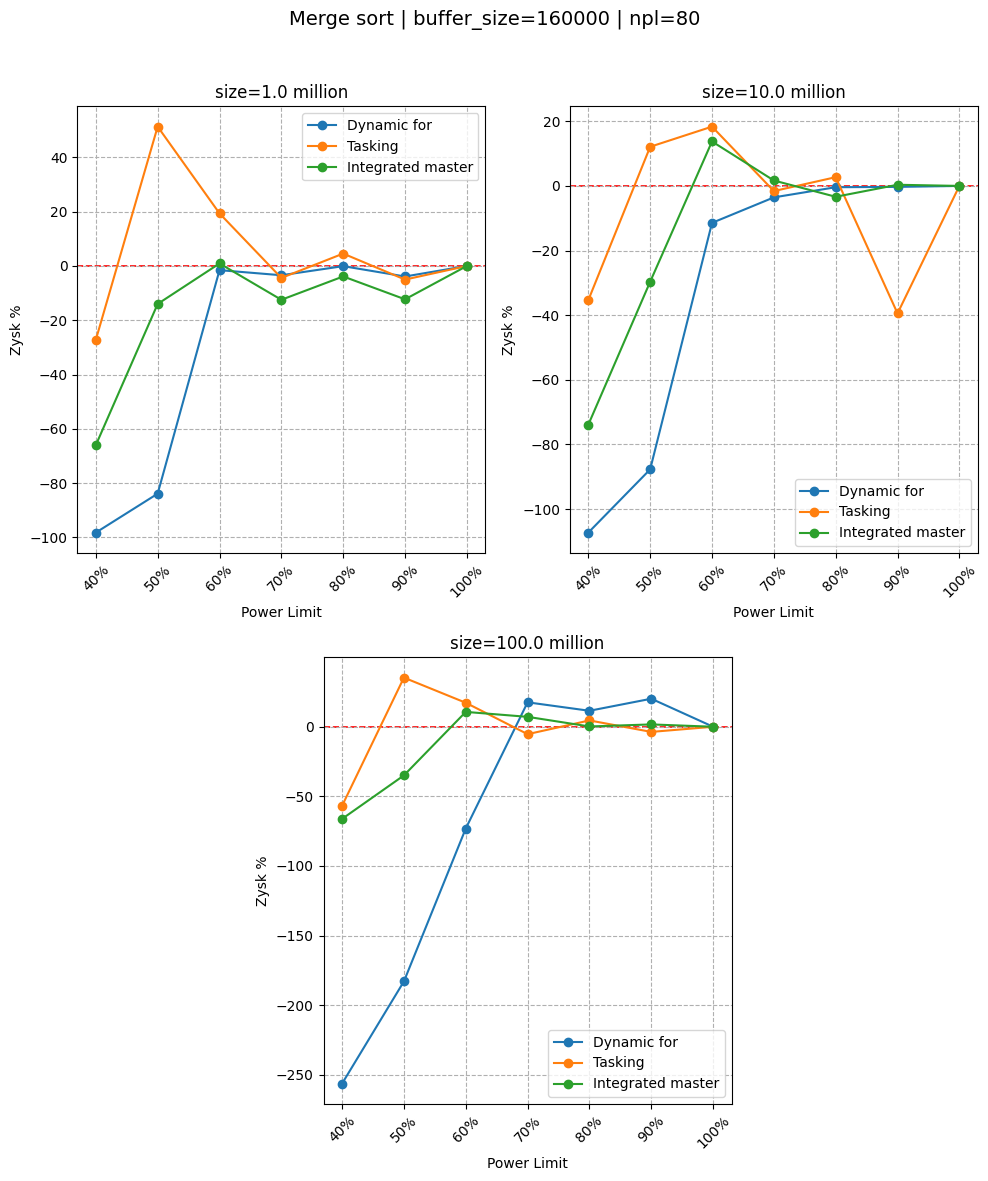

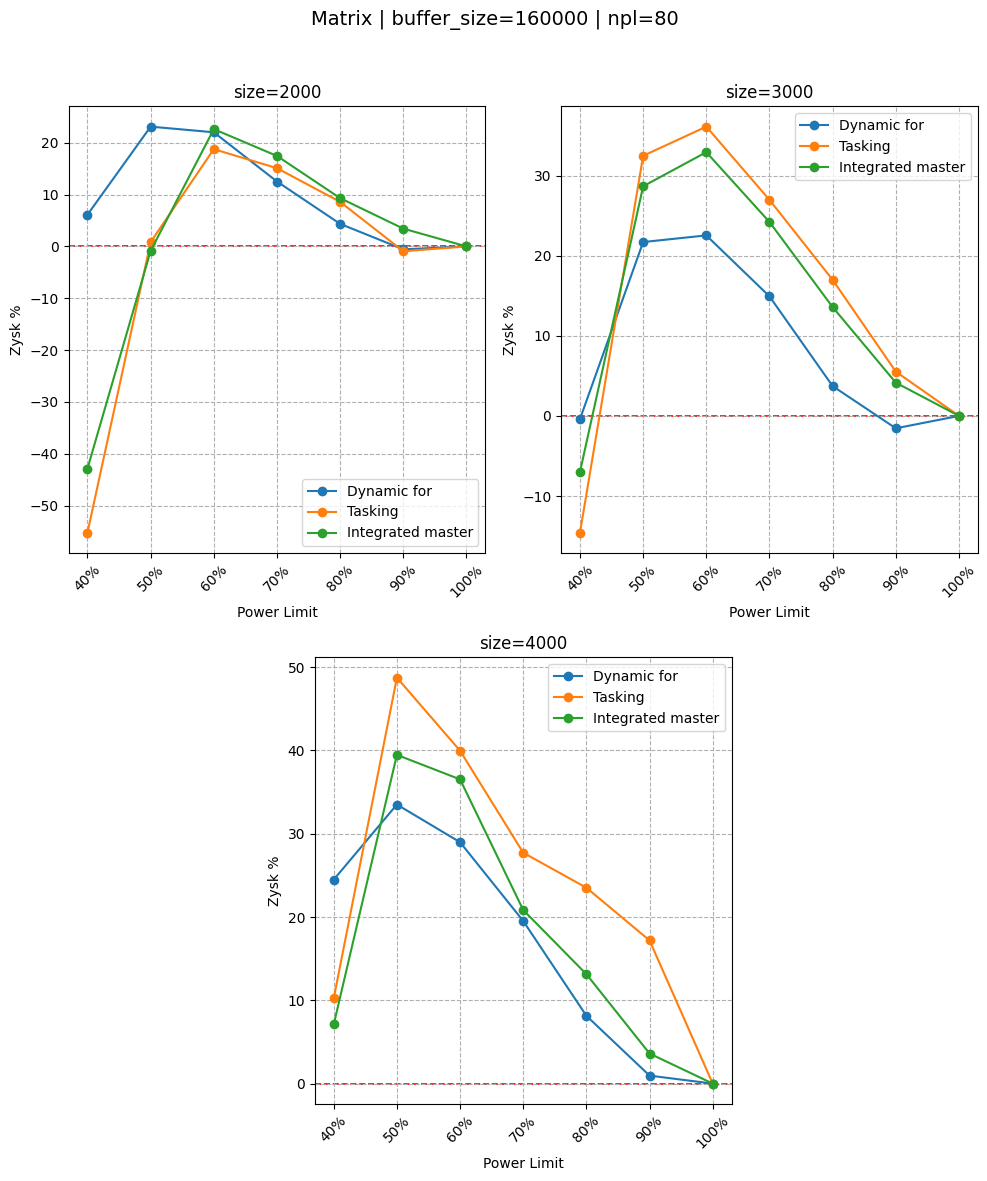

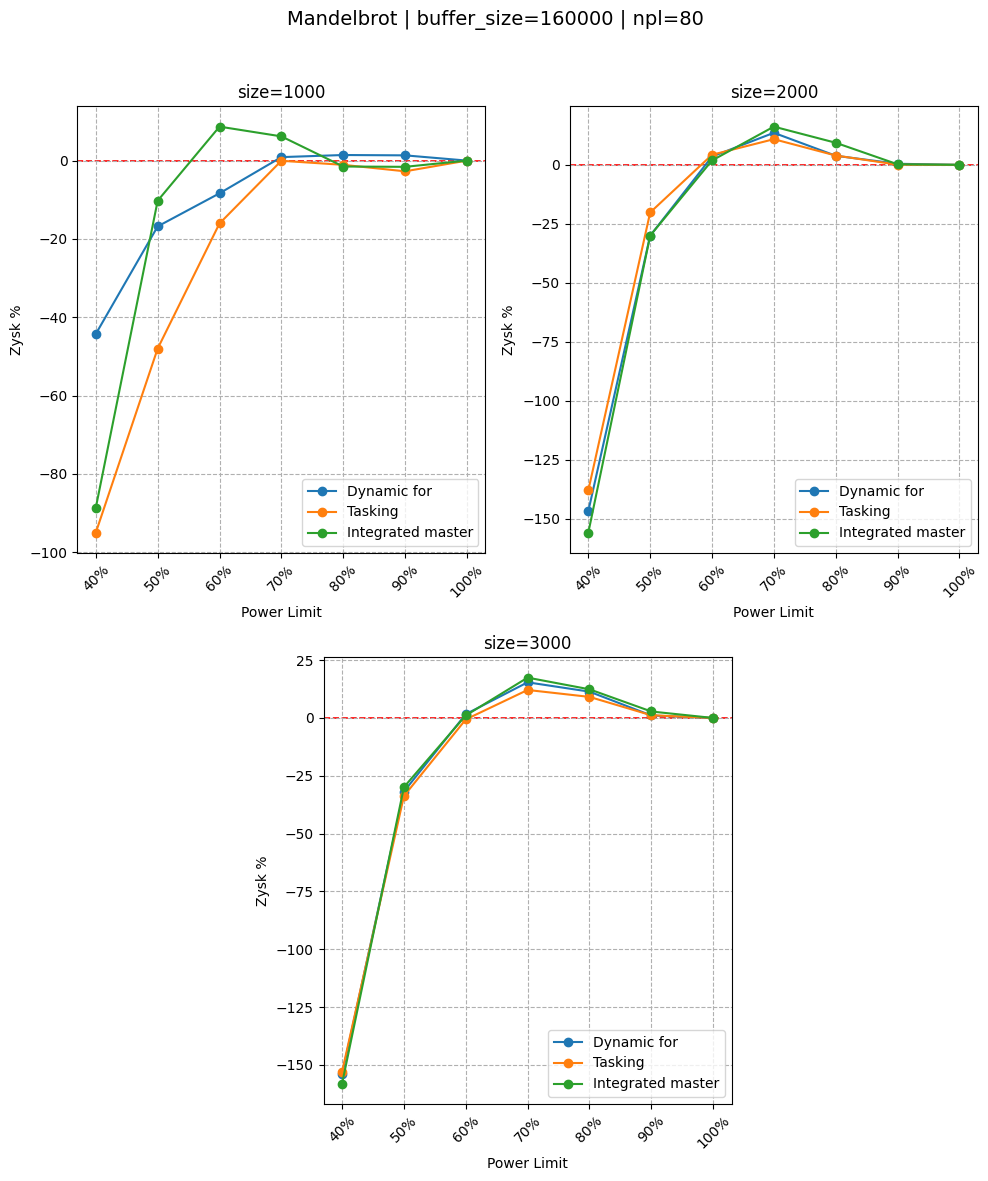

In [7]:
range_min = "40"
for config in program_configs:
    program_name = config["name"]
    program_title = config["title"]
    csv_path = config["csv_path"]

    try:
        df = pd.read_csv(csv_path, sep=None, engine="python")
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, sep=None, engine="python", encoding="cp1250")

    df.columns = df.columns.str.strip()
    rows, cols = 2, 4

    df = df.copy()
    df["energy_J"] = df["energy_used_RAPL"] / 1e6
    df_base = df[(df["buffer_size"] == buffer_size) & (df["npl"] == NPROC)].copy()


    grp_cols = ["model", "power_limit", "problem_size"]
    df_agg = (
        df_base.groupby(grp_cols, as_index=False)
              .agg(
                  working_time_mean=("working_time", "mean"),
                  working_time_std =("working_time", "std"),
                  energy_J_mean    =("energy_J", "mean"),
                  energy_J_std     =("energy_J", "std"),
                  count            =("working_time", "size")
              )
    )
    df_agg[["working_time_std","energy_J_std"]] = df_agg[["working_time_std","energy_J_std"]].fillna(0)

    fig = plt.figure(figsize=( (cols/2)*5, rows*6) )
    gs = gridspec.GridSpec(rows, cols, figure=fig)

    size_values = df_agg['problem_size'].unique()

    for i, size_val in enumerate(size_values):
        if i==2:
            ax = fig.add_subplot(gs[1, 1:3])
        else:
            r, c_base = divmod(i, 2)
            c_start = c_base * 2
            ax = fig.add_subplot(gs[r, c_start:c_start+2])

        for model_id, model_name in model_names.items():
            df_plot = df_agg[
                (df_agg['problem_size'] == size_val) &
                (df_agg['model'] == model_id)
            ].sort_values("power_limit")

            skip_rows = int(int(range_min) / 10 - 1)
            df_plot = df_plot.iloc[skip_rows:].reset_index(drop=True)

            max_pl = df_plot["power_limit"].max()
            ref_rows = df_plot.loc[df_plot['power_limit'] == max_pl]
            ref_row = ref_rows.iloc[0]
            ref_energy = ref_row['energy_J_mean']
            ref_time = ref_row['working_time_mean']

            df_plot["energy_gain_%"] = (1 - df_plot["energy_J_mean"] / ref_energy) * 100
            df_plot["performance_loss_%"] = (df_plot["working_time_mean"] / ref_time - 1) * 100

            y = df_plot["energy_gain_%"] - df_plot["performance_loss_%"]
            #y = df_plot['energy_J_mean'] * df_plot['working_time_mean']

            x = df_plot['power_limit']
            ax.plot(x, y, marker='o', label=model_name)

        if program_name == "ms":
            ax.set_title(f'size={size_val/1e6} million')
        else:
            ax.set_title(f'size={size_val}')
        ax.set_xlabel('Power Limit')
        ax.set_ylabel(r'Zysk %')
        #ax.set_yscale('log')
        #ax.set_ylim(bottom=-8)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1.2, zorder=0)
        ax.grid(True, which='both', ls='--')
        ax.legend()
        ax.set_xticks(x)
        ax.set_xticklabels([f"{i}%" for i in range(int(range_min), 101, 10)], rotation=45)


    plt.suptitle(f"{program_title} | buffer_size={int(buffer_size)} | npl={NPROC}", fontsize=14) # Zwiększyłem czcionkę
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("wszystkie_9x4.png", dpi=300)
    plt.show()


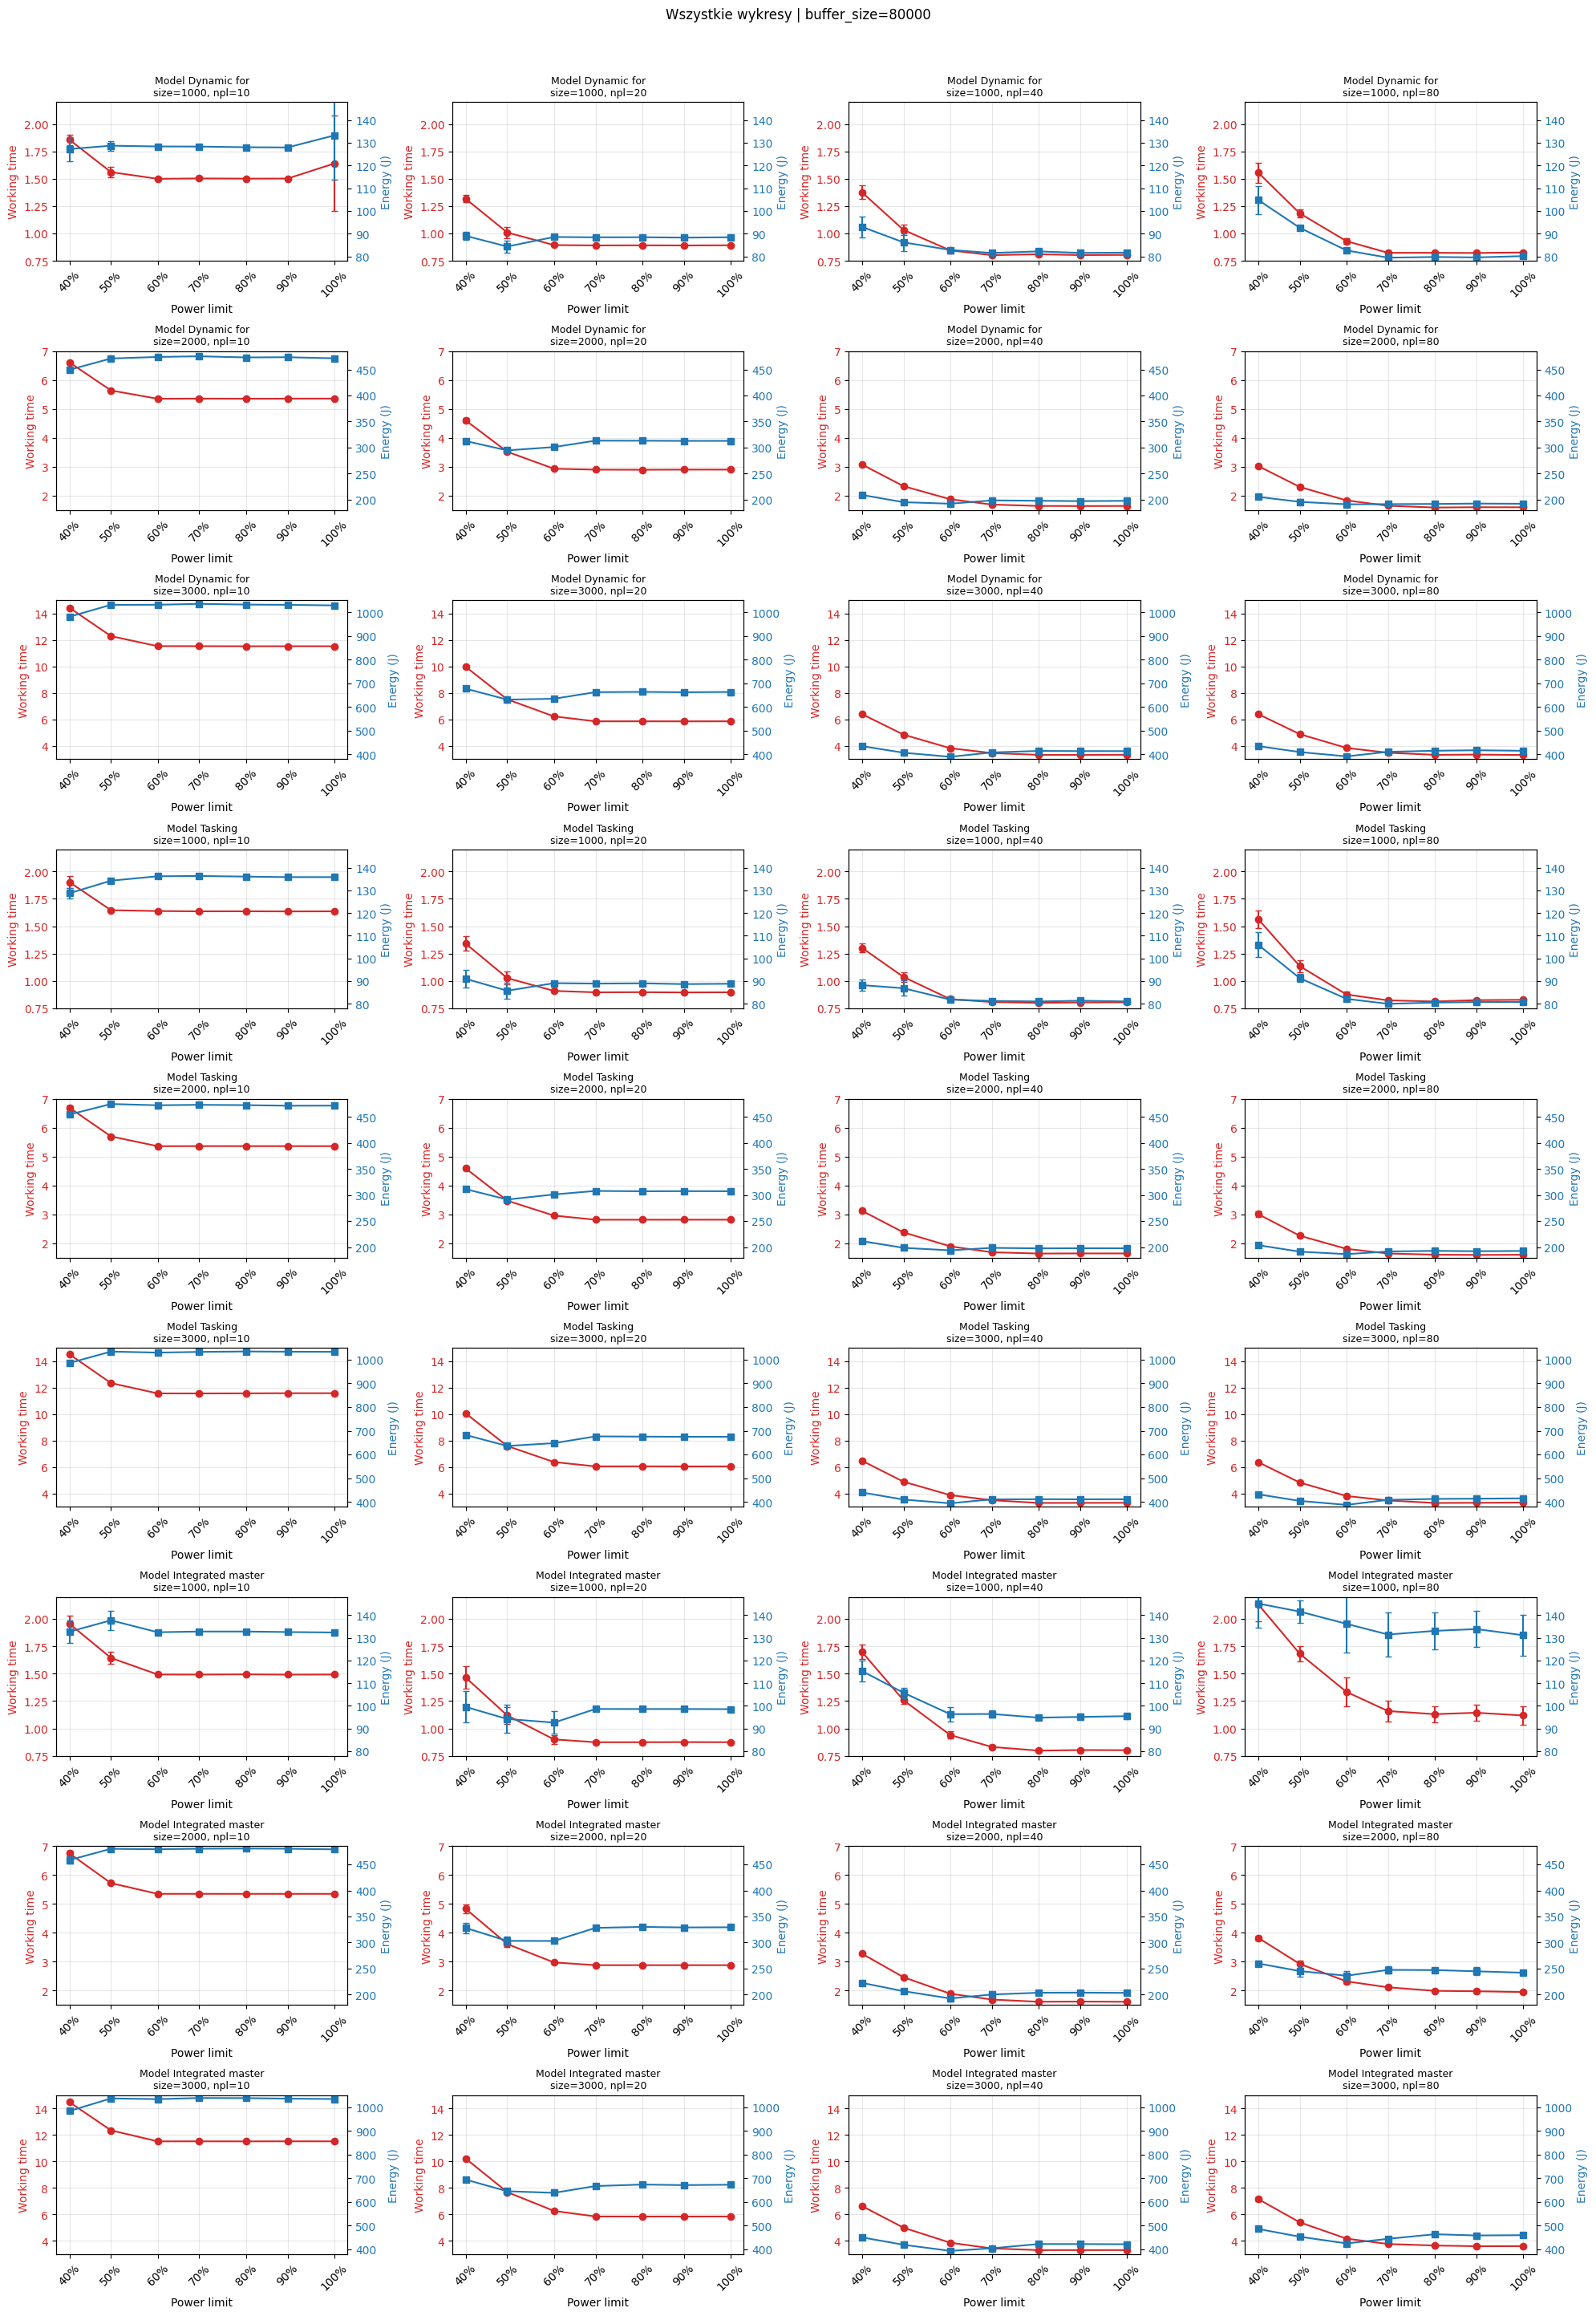

In [ ]:
csv_path = "/content/drive/MyDrive/mgr/final/vinnana/mb_results.csv"
try:
    df = pd.read_csv(csv_path, sep=None, engine="python")
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="cp1250")


buffer_size = 80000
rows, cols = 9, 4
total_plots = rows * cols

model_names = {
    0: "Dynamic for",
    1: "Tasking",
    2: "Integrated master"
}


df = df.copy()
df["energy_J"] = df[" energy_used_RAPL"] / 1e6


df_base = df[df[" buffer_size"] == buffer_size].copy()


grp_cols = ["model", " power_limit", " problem_size", " npl", " buffer_size"]
df_agg = (
    df_base.groupby(grp_cols, as_index=False)
           .agg(
               working_time_mean=(" working_time", "mean"),
               working_time_std =(" working_time", "std"),
               energy_J_mean    =("energy_J", "mean"),
               energy_J_std     =("energy_J", "std"),
               count            =(" working_time", "size")
           )
)
df_agg[["working_time_std","energy_J_std"]] = df_agg[["working_time_std","energy_J_std"]].fillna(0)


triplets = (
    df_agg[["model", " problem_size", " npl"]]
    .drop_duplicates()
    .sort_values([" model" if " model" in df_agg.columns else "model", " problem_size", " npl"],
                 kind="stable")
    .to_records(index=False)
)
triplets = [(t[0], t[1], t[2]) for t in triplets]


triplets = triplets[:total_plots]

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3.2), squeeze=False)

for i, (model, problem_size, npl) in enumerate(triplets):
    r, c = divmod(i, cols)
    ax1 = axes[r][c]
    ax2 = ax1.twinx()

    sub = (
        df_agg[(df_agg["model"] == model) &
               (df_agg[" problem_size"] == problem_size) &
               (df_agg[" npl"] == npl)]
        .sort_values(" power_limit")
        .iloc[3:]
    )
    if sub.empty:
        ax1.set_visible(False)
        continue

    # --- Working time (Y1) ---
    color1 = "tab:red"
    #ax1.set_yscale("log")
    ax1.errorbar(sub[" power_limit"], sub["working_time_mean"],
                 yerr=sub["working_time_std"], fmt="-o", capsize=3, color=color1)
    ax1.set_ylabel("Working time", color=color1)
    ax1.tick_params(axis="y", labelcolor=color1)

    # --- Energy (Y2) ---
    color2 = "tab:blue"
    #ax2.set_yscale("log")
    ax2.errorbar(sub[" power_limit"], sub["energy_J_mean"],
                 yerr=sub["energy_J_std"], fmt="-s", capsize=3, color=color2)
    ax2.set_ylabel("Energy (J)", color=color2)
    ax2.tick_params(axis="y", labelcolor=color2)


    ax1.set_xlabel("Power limit")
    ax1.grid(True, which="major", axis="both", alpha=0.3)
    ax2.grid(False)

    ax1.set_title(f"Model {model_names.get(model, model)}\nsize={int(problem_size)}, npl={int(npl)}", fontsize=9)

    ax1.set_xticks(sub[" power_limit"])
    ax1.set_xticklabels([f"{i}%" for i in range(40, 101, 10)], rotation=45)

for j in range(len(triplets), total_plots):
    r, c = divmod(j, cols)
    axes[r][c].set_visible(False)

plt.tight_layout()
plt.suptitle(f"Wszystkie wykresy | buffer_size={int(buffer_size)}", y=1.001, fontsize=12)
plt.subplots_adjust(top=0.96)
plt.savefig("wszystkie_9x4.png", dpi=300)
plt.show()
